# Lab 2: Regression

Welcome to Lab 2 of Data 8.3x!

Today we will get some hands-on practice with linear regression. You can find more information about this topic in
[section 15.2](https://www.inferentialthinking.com/chapters/15/2/Regression_Line).

In [1]:
# Run this cell, but please don't change it.

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)

# These lines load the tests.
from okgrade import grade

## 1. How Faithful is Old Faithful? Revisited

Let's revisit a question from lab 1. Last lab, we investigated Old Faithful, a geyser in Yellowstone National Park in the central United States. It's famous for erupting on a fairly regular schedule.

To recap, some of Old Faithful's eruptions last longer than others. Today, we will use the same dataset on eruption durations and waiting times to see if we can make predict the wait time from the eruption duration using linear regression.

The dataset has one row for each observed eruption.  It includes the following columns:
- **duration**: Eruption duration, in minutes
- **wait**: Time between this eruption and the next, also in minutes

Run the next cell to load the dataset.

In [2]:
faithful = Table.read_table("faithful.csv")
faithful

duration,wait
3.6,79
1.8,54
3.333,74
2.283,62
4.533,85
2.883,55
4.7,88
3.6,85
1.95,51
4.35,85


Remember from last lab that we concluded eruption time and waiting time are positively correlated. The table below called `faithful_standard` contains the eruption durations and waiting times in standard units.

In [3]:
duration_mean = np.mean(faithful.column("duration"))
duration_std = np.std(faithful.column("duration"))
wait_mean = np.mean(faithful.column("wait"))
wait_std = np.std(faithful.column("wait"))

faithful_standard = Table().with_columns(
    "duration (standard units)", (faithful.column("duration") - duration_mean) / duration_std,
    "wait (standard units)", (faithful.column("wait") - wait_mean) / wait_std
)
faithful_standard

duration (standard units),wait (standard units)
0.0984989,0.597123
-1.48146,-1.24518
-0.135861,0.228663
-1.0575,-0.655644
0.917443,1.03928
-0.530851,-1.17149
1.06403,1.26035
0.0984989,1.03928
-1.3498,-1.46626
0.756814,1.03928


The next cell computes the correlation `r`

In [4]:
r = np.mean(faithful_standard.column(0) * faithful_standard.column(1))
r

0.9008111683218132

## 2. The regression line
The correlation coefficient is the slope of the regression line when the data are expressed in standard units.

The next cell plots the regression line in standard units:

$$\text{waiting time (standard units)} = r \times \text{eruption duration (standard units)}.$$

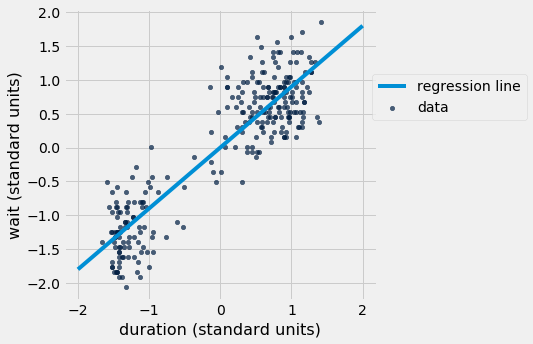

In [5]:
def plot_data_and_line(dataset, x, y, point_0, point_1):
    """Makes a scatter plot of the dataset, along with a line passing through two points."""
    dataset.scatter(x, y, label="data")
    xs, ys = zip(point_0, point_1)
    plots.plot(xs, ys, label="regression line")
    plots.legend(bbox_to_anchor=(1.5,.8))

plot_data_and_line(faithful_standard, 
                   "duration (standard units)", 
                   "wait (standard units)", 
                   [-2, -2*r], 
                   [2, 2*r])

How would you take a point in standard units and convert it back to original units?  We'd have to "stretch" its horizontal position by `duration_std` and its vertical position by `wait_std`.

That means the same thing would happen to the slope of the line.

Stretching a line horizontally makes it less steep, so we divide the slope by the stretching factor.  Stretching a line vertically makes it more steep, so we multiply the slope by the stretching factor.

** Question 2.1 **<br/>
What is the slope of the regression line in original units?

(If the "stretching" explanation is unintuitive, consult section [15.2](https://www.inferentialthinking.com/chapters/15/2/Regression_Line) in the textbook.)

In [6]:
slope = wait_std / duration_std * r
slope

10.729641395133527

We know that the regression line passes through the point `(duration_mean, wait_mean)`.  You might recall from high-school algebra that the equation for the line is therefore:

$$\text{waiting time} - \verb|wait_mean| = \texttt{slope} \times (\text{eruption duration} - \verb|duration_mean|)$$

After rearranging that equation slightly, the intercept turns out to be:

In [8]:
intercept = slope*(-duration_mean) + wait_mean
intercept

33.47439702275335

In [9]:
grade('tests/q2_1.py')

## 3. Investigating the regression line
The slope and intercept tell you exactly what the regression line looks like.  To predict the waiting time for an eruption, multiply the eruption's duration by `slope` and then add `intercept`.

** Question 3.1 ** <br/>
Compute the predicted waiting time for an eruption that lasts 2 minutes, and for an eruption that lasts 5 minutes.

In [11]:
two_minute_predicted_waiting_time = 2 * slope + intercept
five_minute_predicted_waiting_time = 5 * slope + intercept

# Here is a helper function to print out your predictions
# (you don't need to modify it):
def print_prediction(duration, predicted_waiting_time):
    print("After an eruption lasting", duration,
          "minutes, we predict you'll wait", predicted_waiting_time,
          "minutes until the next eruption.")

print_prediction(2, two_minute_predicted_waiting_time)
print_prediction(5, five_minute_predicted_waiting_time)

After an eruption lasting 2 minutes, we predict you'll wait 54.933679813020404 minutes until the next eruption.
After an eruption lasting 5 minutes, we predict you'll wait 87.12260399842098 minutes until the next eruption.


In [12]:
grade('tests/q3_1.py')

The next cell plots the line that goes between those two points, which is (a segment of) the regression line.

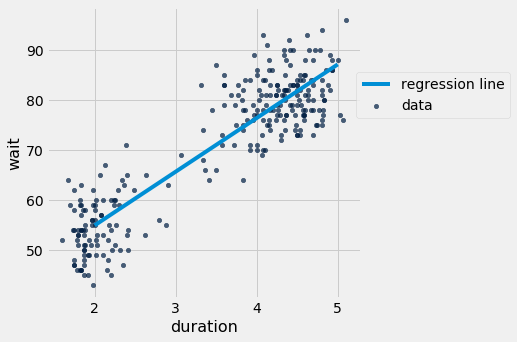

In [13]:
plot_data_and_line(faithful, "duration", "wait", 
                   [2, two_minute_predicted_waiting_time], 
                   [5, five_minute_predicted_waiting_time])

** Question 3.2 ** <br/>
Make predictions for the waiting time after each eruption in the `faithful` table.  (Of course, we know exactly what the waiting times were!  We are doing this so we can see how accurate our predictions are.)  Put these numbers into a column in a new table called `faithful_predictions`.  Its first row should look like this:

|duration|wait|predicted wait|
|-|-|-|
|3.6|79|72.1011|

*Hint:* Your answer can be just one line.  There is no need for a `for` loop; use array arithmetic instead.

In [21]:
def estimate(x):
    return x * slope + intercept
faithful_predictions = faithful.with_columns(
    'predicted wait', faithful.apply(estimate, 'duration')
)
# faithful
faithful_predictions

duration,wait,predicted wait
3.6,79,72.1011
1.8,54,52.7878
3.333,74,69.2363
2.283,62,57.9702
4.533,85,82.1119
2.883,55,64.408
4.7,88,83.9037
3.6,85,72.1011
1.95,51,54.3972
4.35,85,80.1483


In [22]:
grade('tests/q3_2.py')

** Question 3.3 ** <br/>
How close were we?  We computed the *residual* for each eruption in the dataset.  The residual is the difference (not the absolute difference) between the actual waiting time and the predicted waiting time.  Add the residuals to `faithful_predictions` as a new column called `"residual"`, naming the resulting table `faithful_residuals`.

*Hint:* Again, your code will be much simpler if you don't use a `for` loop.

In [24]:
residual = faithful_predictions.column(1) - faithful_predictions.column(2)
faithful_residuals = faithful_predictions.with_columns(
    'residual', residual
)
faithful_residuals

duration,wait,predicted wait,residual
3.6,79,72.1011,6.89889
1.8,54,52.7878,1.21225
3.333,74,69.2363,4.76371
2.283,62,57.9702,4.02983
4.533,85,82.1119,2.88814
2.883,55,64.408,-9.40795
4.7,88,83.9037,4.09629
3.6,85,72.1011,12.8989
1.95,51,54.3972,-3.3972
4.35,85,80.1483,4.85166


In [25]:
grade('tests/q3_3.py')

Here is a plot of the residuals you computed.  Each point corresponds to one eruption.  It shows how much our prediction over- or under-estimated the waiting time.

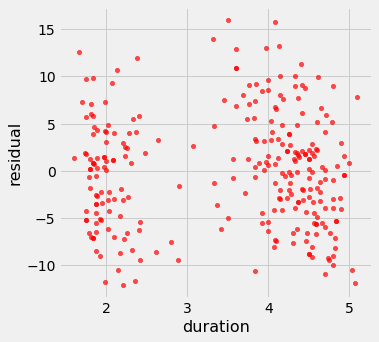

In [26]:
faithful_residuals.scatter("duration", "residual", color="r")

There isn't too much of a pattern in the residuals, which confirms that it's reasonable to use linear regression for prediction.  It's true that there are two separate clouds; the eruption durations seemed to fall into two distinct clusters.  But that's just a pattern in the eruption durations, not a pattern in the relationship between eruption durations and waiting times. A larger concern is that there may be more positive than negative residuals in a particular region of the horizontal axis. For both clusters, the points are distributed fairly evenly above and below zero, which is a confirmation that the association is mostly linear.

## 4. How accurate are different predictions?
The correlation coefficient is close to 1, implying that the observed values are tightly clustered around the regression line.  The residuals are overall small (close to 0) in comparison to the waiting times.

We can see that visually by plotting the waiting times and residuals together:

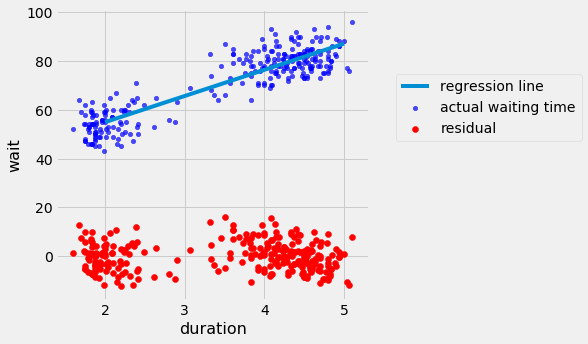

In [27]:
faithful_residuals.scatter("duration", "wait", label="actual waiting time", color="blue")
plots.scatter(faithful_residuals.column("duration"), faithful_residuals.column("residual"), label="residual", color="r")
plots.plot([2, 5], [two_minute_predicted_waiting_time, five_minute_predicted_waiting_time], label="regression line")
plots.legend(bbox_to_anchor=(1.7,.8));

** Question 4.1 ** <br/>
In `faithful`, no eruption lasted exactly 0, 2.5, or 60 minutes.  Using this line, what is the predicted waiting time for an eruption that lasts 0 minutes?  2.5 minutes?  An hour?

In [28]:
zero_minute_predicted_waiting_time = 0 * slope + intercept
two_point_five_minute_predicted_waiting_time = 2.5 * slope + intercept
hour_predicted_waiting_time = 60 * slope + intercept

print_prediction(0, zero_minute_predicted_waiting_time)
print_prediction(2.5, two_point_five_minute_predicted_waiting_time)
print_prediction(60, hour_predicted_waiting_time)

After an eruption lasting 0 minutes, we predict you'll wait 33.47439702275335 minutes until the next eruption.
After an eruption lasting 2.5 minutes, we predict you'll wait 60.29850051058717 minutes until the next eruption.
After an eruption lasting 60 minutes, we predict you'll wait 677.252880730765 minutes until the next eruption.


In [29]:
grade('tests/q4_1.py')

## 5. Divide and Conquer

Let's see what happens if we treat the two clusters of observations differently. It appears from the scatter diagram that there are two clusters of points: one for durations around 2 and another for durations between 3.5 and 5. A vertical line at 3 divides the two clusters.

In [ ]:
faithful.scatter("duration", "wait", label="actual waiting time", color="blue")
plots.plot([3, 3], [40, 100]);

The `standardize` function from lecture appears below, which returns a table of values in standard units.

In [ ]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers)) / np.std(any_numbers)  

def standardize(t):
    """Return a table in which all columns of t are converted to standard units."""
    t_su = Table()
    for label in t.labels:
        t_su = t_su.with_column(label + ' (su)', standard_units(t.column(label)))
    return t_su

**Question 5.1** <br/>
Separately compute the regression coefficients *r* for all the points with a duration below 3 **and then** for all the points with a duration above 3. To do so, create a function that computes `r` from a table and pass it two different tables of points, `below_3` and `above_3`.

In [ ]:
def reg_coeff(t):
    """Return the regression coefficient for columns 0 & 1."""
    t_su = standardize(t)
    ...

below_3 = ...
above_3 = ...
below_3_r = reg_coeff(below_3)
above_3_r = reg_coeff(above_3)
print("For points below 3, r is", below_3_r, "; for points above 3, r is", above_3_r)

In [ ]:
grade('tests/q5_1.py')

**Question 5.2** <br/>
Write functions `slope_of` and `intercept_of` below. 

When you're done, the functions `wait_below_3` and `wait_above_3` should each use a different regression line to predict a wait time for a duration. The first function should use the regression line for all points with duration below 3.2. The second function should use the regression line for all points with duration above 3.2.

In [ ]:
def slope_of(t, r):
    """Return the slope of the regression line for t in original units.
    
    Assume that column 0 contains x values and column 1 contains y values.
    r is the regression coefficient for x and y.
    """
    ...

def intercept_of(t, r):
    """Return the slope of the regression line for t in original units."""
    s = slope_of(t, r)
    ...
    
below_3_a = slope_of(below_3, below_3_r)
below_3_b = intercept_of(below_3, below_3_r)
above_3_a = slope_of(above_3, above_3_r)
above_3_b = intercept_of(above_3, above_3_r)

def wait_below_3(duration):
    return below_3_a * duration + below_3_b

def wait_above_3(duration):
    return above_3_a * duration + above_3_b

In [ ]:
grade('tests/q5_2.py')

The plot below shows two different regression lines, one for each cluster!

In [ ]:
faithful.scatter(0, 1)
plots.plot([1, 3], [wait_below_3(1), wait_below_3(3)])
plots.plot([3, 6], [wait_above_3(3), wait_above_3(6)]);

**Question 5.3** <br/>
Write a function `predict_wait` that takes a `duration` and returns the predicted wait time using the appropriate regression line, depending on whether the duration is below 3 or greater than (or equal to) 3.

In [ ]:
def predict_wait(duration):
    """Return the wait predicted by the appropriate one of the two regression lines above."""
    ...

In [ ]:
grade('tests/q5_3.py')

The predicted wait times for each point appear below.

In [ ]:
faithful.with_column('predicted', faithful.apply(predict_wait, 'duration')).scatter(0)

**Further Exploration (ungraded)**: When drawing a line through each cluster separately, we discovered two different but similar lines. Here are some natural questions to explore, if you want to continue working with these data:
 * How much more accurate do we expect predictions to be using two lines instead of one? Can we measure this improvement using residuals?
 * Are the lines really different, or did they just come out different due to chance because we have only a small number of observations? How could we tell?
 * Could it be that the slopes of the lines are the same, but the intercepts are different? 

## Submission

You're finished with lab 2! In order to successfully submit your assignment, follow these steps...
- **IMPORTANT** Before you do anything, **Save and Checkpoint** from the `File` menu. Please do this first before running the cell below,
- **run all the tests and verify that they all pass** (the next cell has a shortcut for that), 
- **Review the notebook one last time, we will be grading the final state of your notebook** If you make any changes, please **Save and Checkpoint** again.

In [ ]:
# For your convenience, you can run this cell to run all the tests at once!
import glob
from okgrade.notebook import grade_notebook
if not globals().get('__OKGRADE__', False):
    display(grade_notebook('lab02.ipynb', sorted(glob.glob('tests/q*.py'))))